###Imports and Set Parameters

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
import joblib
from google.colab import files
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict


output_files = False #if True will download df, models, etc
debug = True #if True will print results each step
hyperparameter_tuning = False #if True, run hyperparameter tuning cell
year = 2010 #filters how far back data goes, dramatically impacts runtime
num_display_rows = 50
num_display_cols = None

pd.set_option('display.max_columns', num_display_cols)
pd.set_option('display.max_rows', num_display_rows)
lifts = ['Squat', 'Bench', 'Deadlift']
metrics = lifts + ['Total', 'Dots']

###Get Data

In [ ]:
file_pattern = "openpowerlifting*.csv"
matching_files = glob.glob(file_pattern)

if matching_files:
    df = pd.read_csv(matching_files[0])
else:
    print("No matching files.")

display(df)

NameError: ignored

###Preprocessing

In [ ]:
#set date type
df['Date'] = pd.to_datetime(df['Date'])

#exclude lifters who started competing before year
excluded_lifters = df[df['Date'] < f'{year}-01-01']['Name'].unique()
df = df[~df['Name'].isin(excluded_lifters)]

#only use SBD events
df = df[df['Event'] == 'SBD']

#simplifies feature engineering to rename TotalKg column
df = df.rename(columns={'TotalKg': 'Best3TotalKg'})

#remove guest lifters and disqualified lifters
df = df[~(df['Place'].isin(['DD', 'DQ', 'G', 'NS']) | df['Place'].isnull())]

#not enough data to learn from Mx sex
df = df[df['Sex'] != 'Mx']

#remove missing bodyweight rows
df.dropna(subset=['BodyweightKg'], inplace = True)

#remove missing best 3 lifts
df.dropna(subset=['Best3SquatKg','Best3BenchKg', 'Best3DeadliftKg', 'Best3TotalKg'], inplace = True)

#remove duplicate meets -> if an athlete competes in 2 divisions it will count as 2 entries in the db. It doesnt matter what entry we keep b/c we will remove division column
df = df.drop_duplicates(subset=['MeetName', 'Date', 'Name'], keep='first')

#remove anyone who has only competed in one meet
df = df.groupby('Name').filter(lambda x: len(x) > 1)

#add column indicating a missing age and set missing age to average age
def calculate_average_age(age_range):
    if age_range == 'nan':
      return np.nan
    min_age, max_age = map(int, age_range.split('-'))
    return (min_age + max_age) / 2 if min_age != 80 else min_age

# Replace missing 'Age' values with AgeClass if available else the average age
df['AgeClass'] = df['AgeClass'].astype(str)
df['Age'] = df.apply(lambda row: calculate_average_age(row['AgeClass']) if (pd.isnull(row['Age']) ) else row['Age'], axis=1)
#df['Age'] = df['Age'].fillna(df['Age'].mean())

#remove '+' weight class
df = df.drop(df[df['WeightClassKg'] == '+'].index)

#convert weight classes to floats and remove nan
df.dropna(subset=['WeightClassKg'], inplace = True)
df['WeightClassKg'] = df['WeightClassKg'].astype(str)
df['WeightClassKg'] = df['WeightClassKg'].apply(lambda x: str(float(x[:-1]) + 10) if x.endswith('+') else x)
df['WeightClassKg'] = pd.to_numeric(df['WeightClassKg'])

#remove unused columns
drop_columns = ['Event', 'AgeClass', 'Place', 'BirthYearClass', 'Country',
                'State', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName',
                'ParentFederation', 'Division', 'Squat4Kg', 'Bench4Kg',
                'Deadlift4Kg', 'Tested', 'Goodlift', 'Squat1Kg', 'Squat2Kg',
                'Squat3Kg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Deadlift1Kg',
                'Deadlift2Kg', 'Deadlift3Kg', 'Federation']
df = df.drop(drop_columns, axis=1)

#drop some data and try to balance dataset by undersampling
df = df.groupby('Name').filter(lambda x: np.random.rand() >= .8 or (x['Equipment'] =='Unlimited').any() or (x['Equipment'] == 'Multi-ply').any())

if debug:
  display(df)

,Name,Sex,Equipment,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Best3TotalKg,Dots,Wilks,Glossbrenner,Date
8,Ruslan Gasanov,M,Raw,31.5,102.55,105.0,232.5,160.0,260.0,652.5,397.35,393.25,375.51,2019-05-11
135,Estefanio Climaco Dos Santos,M,Wraps,48.0,106.50,110.0,260.0,135.0,240.0,635.0,380.81,377.60,360.63,2022-09-07
140,Eric Bryce,M,Multi-ply,33.0,104.30,110.0,250.0,175.0,250.0,675.0,408.19,404.31,386.06,2022-09-07
142,Miguel Wagne Sousa Soares,M,Multi-ply,38.0,104.10,110.0,280.0,160.0,330.0,770.0,466.01,461.52,440.69,2022-09-07
144,Lee Powell,M,Multi-ply,38.0,98.90,100.0,275.0,175.0,275.0,725.0,448.41,443.21,423.40,2022-09-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2954284,Lenka Strolená,F,Single-ply,31.5,61.88,63.0,175.0,90.0,175.0,440.0,478.46,479.03,423.09,2016-11-14
2954297,Helga Guðmundsdóttir,F,Single-ply,41.5,66.06,72.0,185.0,135.0,182.5,502.5,525.33,520.93,459.70,2016-11-14
2954298,Nicole Fydrich,F,Single-ply,34.0,68.14,72.0,187.5,105.0,195.0,487.5,500.57,494.21,435.89,2016-11-14
2954307,Sri Rahayu,F,Single-ply,23.5,83.58,84.0,247.5,160.0,195.0,602.5,555.72,538.63,471.06,2016-11-14


###Data Exploration

####Summary Statistics

In [ ]:
# Display summary statistics for numerical columns
print(df.describe())

# Display summary statistics for categorical columns
print(df.describe(include='object'))

                 Age   BodyweightKg  WeightClassKg   Best3SquatKg  \
count  167931.000000  233842.000000  233842.000000  233842.000000   
mean       26.240563      82.773987      85.108934     170.796716   
std        11.037606      23.053914      22.924604      65.272771   
min         5.500000      17.400000      30.000000      15.000000   
25%        18.500000      65.500000      67.300000     120.000000   
50%        22.500000      80.600000      82.500000     165.000000   
75%        31.000000      97.400000     100.000000     210.920000   
max        92.000000     240.000000     165.000000     552.500000   

        Best3BenchKg  Best3DeadliftKg   Best3TotalKg           Dots  \
count  233842.000000    233842.000000  233842.000000  233842.000000   
mean      106.220644       183.289232     460.306311     342.347974   
std        47.664679        59.553041     166.594366      77.311796   
min         7.260000         9.070000      54.000000      49.010000   
25%        67.500000   


*   Failed attempts are negative values
*   3rd attempts have a low mean, we should probably have a boolean feature indicating if the lift was successful



####Correlation Heatmap

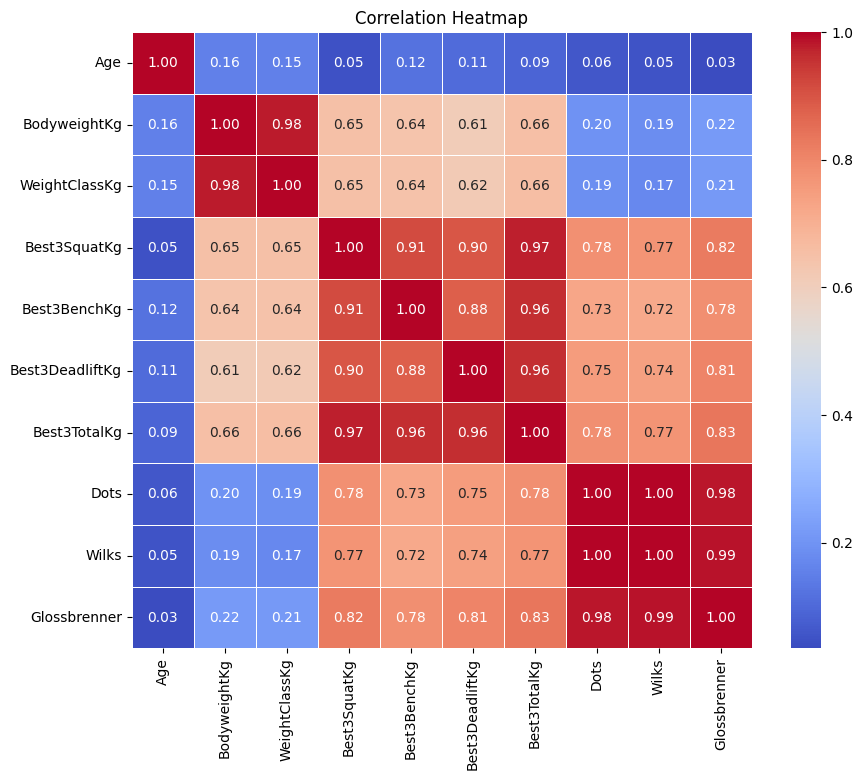

In [ ]:
# Select numerical columns for correlation heatmap
numerical_cols = df.select_dtypes(include='number')

# Calculate correlation matrix
corr_matrix = numerical_cols.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

*   Dots, Wilks, Glossbrenner, Goodlift are all strength metrics
*   Age does not have a strong correlation which is interesting


####Scatter Plots

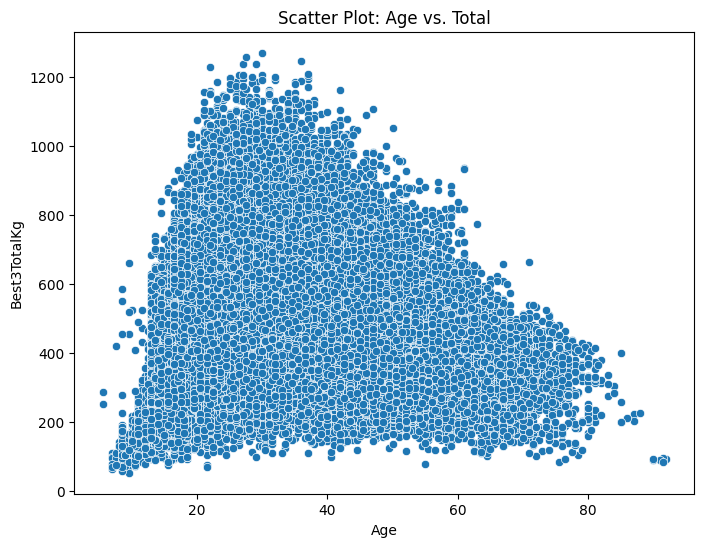

In [ ]:
# Scatter plot between 'Age' and 'TotalKg'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Best3TotalKg', data=df)
plt.title('Scatter Plot: Age vs. Total')
plt.show()



*   We can see how strength peaks around the 20-30 range
*   We can add an age^2 feature to capture the 2 slope relationships



###Feature Engineering

####**Features**
> **metrics**
*   Squat
*   Bench
*   Deadlift
*   Total
*   Dots

> **filters**
*   _N: no filter
*   _E: same weight class

#####**AgeSquared**
> Squared value in age column

#####**DaysSincePreviousMeet{filter}**
> Number of days since the previous meet given the filter

#####**PreviousMeetBodyweight{filter}**
> Bodyweight of the previous meet given the filter

#####**PreviousMeetWeightClass{filter}**
> Weight class of the previous meet given the filter

#####**NumberOfPreviousMeets{filter}**
> Number of previous meet given the filter

#####**AverageBodyweight{filter}**
> Average Bodyweight of previous meets given the filter

#####**BestPrevious{metric}{filter}**
> Best previous metric given the filter

#####**DaysSinceBestPrevious{metric}{filter}**
> Days since best previous metric was achieved given the filter

#####**Average{metric}{filter}**
> Average metric of previous meets given the filter

#####**PreviousMeet{metric}{filter}**
>  metric of the previous meet given the filter

#####**PreviousMeetWeighted{metric}{filter}**
> Weighted (metric/bodyweight) metric of the previous meet given the filter

#####**BestPreviousWeighted{metric}{filter}**
> Best previous weighted metric in a meet given the filter

#####**DaysSinceBestPreviousWeighted{metric}{filter}**
> Days since best previous weighted metric in a meet given the filter

#####**PreviousMeetWeightedChange{metric}{filter}**
> The weighted change of the metric between the two previous meets given the filter

#####**PreviousMeetAverageWeightedChange{metric}{filter}**
> The average weighted change between previous meets given the filter

In [ ]:
def set_days_since_best_previous_metric(row, group, metric, filter):
    best_previous_value = row[f'BestPrevious{metric}{filter}']
    date_before_current = group.loc[
        (group[f'Best3{metric}Kg' if metric != 'Dots' else f'{metric}'] == best_previous_value)
        & (group['Date'] < row['Date']),
        'Date'
    ].max()

    return pd.NaT if pd.isna(date_before_current) else (row['Date'] - date_before_current).days

def set_days_since_best_previous_weighted_metric(row, group, metric, filter):
  best_previous_value = row[f'BestPreviousWeighted{metric}{filter}']
  date_before_current = group.loc[
      (group[f'Best3{metric}Kg'] / group['BodyweightKg'] == best_previous_value)
      & (group['Date'] < row['Date']),
      'Date'
  ].max()

  return pd.NaT if pd.isna(date_before_current) else (row['Date'] - date_before_current).days

def set_features(group, filter):

  group[f'DaysSincePreviousMeet{filter}'] = (group['Date'] - group['Date'].shift()).dt.days
  group[f'PreviousMeetBodyweight{filter}'] = group['BodyweightKg'].shift()
  group[f'PreviousMeetWeightClass{filter}'] = group['WeightClassKg'].shift()

  group[f'NumberOfPreviousMeets{filter}'] = group.groupby('Name').cumcount()

  group[f'AverageBodyweight{filter}'] = group['BodyweightKg'].expanding().mean().shift()

  for metric in metrics:
    group[f'BestPrevious{metric}{filter}'] = group[f'Best3{metric}Kg' if metric != 'Dots' else f'{metric}'].shift().cummax()
    group[f'DaysSinceBestPrevious{metric}{filter}'] = group.apply(set_days_since_best_previous_metric, args=(group, metric, filter), axis=1)

    group[f'Average{metric}{filter}'] = group[f'Best3{metric}Kg' if metric != 'Dots' else f'{metric}'].expanding().mean().shift()

    group[f'PreviousMeet{metric}{filter}'] = group[f'Best3{metric}Kg' if metric != 'Dots' else f'{metric}'].shift()

    if metric != 'Dots':
      group[f'PreviousMeetWeighted{metric}{filter}'] = (group[f'Best3{metric}Kg']/ group[f'BodyweightKg']).shift()
      group[f'BestPreviousWeighted{metric}{filter}'] = (group[f'Best3{metric}Kg'] / group[f'BodyweightKg']).shift().cummax()
      group[f'DaysSinceBestPreviousWeighted{metric}{filter}'] = group.apply(set_days_since_best_previous_weighted_metric, args=(group, metric, filter), axis=1)

      group[f'PreviousMeetWeightedChange{metric}{filter}'] = group[f'PreviousMeetWeighted{metric}{filter}'].diff()
      group[f'PreviousMeetAverageWeightedChange{metric}{filter}'] = group[f'PreviousMeetWeightedChange{metric}{filter}'].expanding().mean()


  return group

df['AgeSquared'] = df['Age'].apply(lambda x: x**2 if not pd.isna(x) else np.nan)

df = df.sort_values(by='Date', ascending=True).groupby(['Name'], group_keys=False).apply(set_features, filter = '_N')
print("1/3 DONE")
df = df.sort_values(by='Date', ascending=True).groupby(['Name', 'WeightClassKg'], group_keys=False).apply(set_features, filter = '_W')
print("2/3 DONE")
df = df.sort_values(by='Date', ascending=True).groupby(['Name', 'WeightClassKg', 'Equipment'], group_keys=False).apply(set_features, filter = '_WE')


if debug: display(df.sort_values(by=['Name','Date']))

1/3 DONE
2/3 DONE


,Name,Sex,Equipment,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Best3TotalKg,Dots,Wilks,Glossbrenner,Date,AgeSquared,DaysSincePreviousMeet_N,PreviousMeetBodyweight_N,PreviousMeetWeightClass_N,NumberOfPreviousMeets_N,AverageBodyweight_N,BestPreviousSquat_N,DaysSinceBestPreviousSquat_N,AverageSquat_N,PreviousMeetSquat_N,PreviousMeetWeightedSquat_N,BestPreviousWeightedSquat_N,DaysSinceBestPreviousWeightedSquat_N,PreviousMeetWeightedChangeSquat_N,PreviousMeetAverageWeightedChangeSquat_N,BestPreviousBench_N,DaysSinceBestPreviousBench_N,AverageBench_N,PreviousMeetBench_N,PreviousMeetWeightedBench_N,BestPreviousWeightedBench_N,DaysSinceBestPreviousWeightedBench_N,PreviousMeetWeightedChangeBench_N,PreviousMeetAverageWeightedChangeBench_N,BestPreviousDeadlift_N,DaysSinceBestPreviousDeadlift_N,AverageDeadlift_N,PreviousMeetDeadlift_N,PreviousMeetWeightedDeadlift_N,BestPreviousWeightedDeadlift_N,DaysSinceBestPreviousWeightedDeadlift_N,PreviousMeetWeightedChangeDeadlift_N,PreviousMeetAverageWeightedChangeDeadlift_N,BestPreviousTotal_N,DaysSinceBestPreviousTotal_N,AverageTotal_N,PreviousMeetTotal_N,PreviousMeetWeightedTotal_N,BestPreviousWeightedTotal_N,DaysSinceBestPreviousWeightedTotal_N,PreviousMeetWeightedChangeTotal_N,PreviousMeetAverageWeightedChangeTotal_N,BestPreviousDots_N,DaysSinceBestPreviousDots_N,AverageDots_N,PreviousMeetDots_N,DaysSincePreviousMeet_W,PreviousMeetBodyweight_W,PreviousMeetWeightClass_W,NumberOfPreviousMeets_W,AverageBodyweight_W,BestPreviousSquat_W,DaysSinceBestPreviousSquat_W,AverageSquat_W,PreviousMeetSquat_W,PreviousMeetWeightedSquat_W,BestPreviousWeightedSquat_W,DaysSinceBestPreviousWeightedSquat_W,PreviousMeetWeightedChangeSquat_W,PreviousMeetAverageWeightedChangeSquat_W,BestPreviousBench_W,DaysSinceBestPreviousBench_W,AverageBench_W,PreviousMeetBench_W,PreviousMeetWeightedBench_W,BestPreviousWeightedBench_W,DaysSinceBestPreviousWeightedBench_W,PreviousMeetWeightedChangeBench_W,PreviousMeetAverageWeightedChangeBench_W,BestPreviousDeadlift_W,DaysSinceBestPreviousDeadlift_W,AverageDeadlift_W,PreviousMeetDeadlift_W,PreviousMeetWeightedDeadlift_W,BestPreviousWeightedDeadlift_W,DaysSinceBestPreviousWeightedDeadlift_W,PreviousMeetWeightedChangeDeadlift_W,PreviousMeetAverageWeightedChangeDeadlift_W,BestPreviousTotal_W,DaysSinceBestPreviousTotal_W,AverageTotal_W,PreviousMeetTotal_W,PreviousMeetWeightedTotal_W,BestPreviousWeightedTotal_W,DaysSinceBestPreviousWeightedTotal_W,PreviousMeetWeightedChangeTotal_W,PreviousMeetAverageWeightedChangeTotal_W,BestPreviousDots_W,DaysSinceBestPreviousDots_W,AverageDots_W,PreviousMeetDots_W,DaysSincePreviousMeet_WE,PreviousMeetBodyweight_WE,PreviousMeetWeightClass_WE,NumberOfPreviousMeets_WE,AverageBodyweight_WE,BestPreviousSquat_WE,DaysSinceBestPreviousSquat_WE,AverageSquat_WE,PreviousMeetSquat_WE,PreviousMeetWeightedSquat_WE,BestPreviousWeightedSquat_WE,DaysSinceBestPreviousWeightedSquat_WE,PreviousMeetWeightedChangeSquat_WE,PreviousMeetAverageWeightedChangeSquat_WE,BestPreviousBench_WE,DaysSinceBestPreviousBench_WE,AverageBench_WE,PreviousMeetBench_WE,PreviousMeetWeightedBench_WE,BestPreviousWeightedBench_WE,DaysSinceBestPreviousWeightedBench_WE,PreviousMeetWeightedChangeBench_WE,PreviousMeetAverageWeightedChangeBench_WE,BestPreviousDeadlift_WE,DaysSinceBestPreviousDeadlift_WE,AverageDeadlift_WE,PreviousMeetDeadlift_WE,PreviousMeetWeightedDeadlift_WE,BestPreviousWeightedDeadlift_WE,DaysSinceBestPreviousWeightedDeadlift_WE,PreviousMeetWeightedChangeDeadlift_WE,PreviousMeetAverageWeightedChangeDeadlift_WE,BestPreviousTotal_WE,DaysSinceBestPreviousTotal_WE,AverageTotal_WE,PreviousMeetTotal_WE,PreviousMeetWeightedTotal_WE,BestPreviousWeightedTotal_WE,DaysSinceBestPreviousWeightedTotal_WE,PreviousMeetWeightedChangeTotal_WE,PreviousMeetAverageWeightedChangeTotal_WE,BestPreviousDots_WE,DaysSinceBestPreviousDots_WE,AverageDots_WE,PreviousMeetDots_WE
2499038,A Lai,M,Single-ply,NaN,123.97,124.7,158.76,83.91,190.51,433.18,246.15,247.27,236.77,2010-01-25,NaN,

###Processing

In [ ]:
#drop unused columns
drop_columns = ['Name', 'Date', 'Best3TotalKg', 'Dots', 'Wilks', 'Glossbrenner',
                'Equipment']
df = df.drop(drop_columns, axis=1)

#use one hot encoding for categorical columns
categorical_columns = ['Sex']
df = pd.get_dummies(df, columns = categorical_columns)

for column in df.columns:
    if 'DaysSince' in column:
        df[column] = df[column].apply(lambda x: None if pd.isna(x) else x)

original_features = ['Age', 'WeightClassKg', 'AgeSquared'] + [feature for feature in df.columns
                                                              if 'DaysSincePreviousMeet' in feature
                                                              or 'PreviousMeetBodyweight' in feature
                                                              or 'PreviousMeetWeightClass' in feature
                                                              or 'NumberOfPreviousMeets' in feature
                                                              or 'AverageBodyweight' in feature
                                                              or 'Sex' in feature
                                                              or 'Dots' in feature
                                                              or 'Total' in feature]

bodyweight_features = list(filter(lambda x: x not in ['Best3SquatKg', 'Best3BenchKg', 'Best3TotalKg'], original_features))
squat_features = original_features + [feature for feature in df.columns if 'Squat' in feature]
bench_features = original_features + [feature for feature in df.columns if 'Bench' in feature]
deadlift_features = original_features + [feature for feature in df.columns if 'Deadlift' in feature]

def set_df(df, features, target_column):
  new_df = df[features].copy()
  new_df = new_df.reindex(sorted(new_df.columns), axis=1) #sort alphabetically
  new_column_order = [target_column] + [col for col in new_df.columns if col != target_column]
  return df[new_column_order]


bodyweight_df = set_df(df, bodyweight_features, 'BodyweightKg')
squat_df = set_df(df, squat_features, 'Best3SquatKg')
bench_df = set_df(df, bench_features, 'Best3BenchKg')
deadlift_df = set_df(df, deadlift_features, 'Best3DeadliftKg')

if debug:
  display(squat_df)
  display(bench_df)
  display(deadlift_df)
  display(bodyweight_df)

,Age,WeightClassKg,AgeSquared,AverageBodyweight_N,AverageBodyweight_W,AverageBodyweight_WE,AverageDots_N,AverageDots_W,AverageDots_WE,AverageTotal_N,AverageTotal_W,AverageTotal_WE,BestPreviousDots_N,BestPreviousDots_W,BestPreviousDots_WE,BestPreviousTotal_N,BestPreviousTotal_W,BestPreviousTotal_WE,BestPreviousWeightedTotal_N,BestPreviousWeightedTotal_W,BestPreviousWeightedTotal_WE,DaysSinceBestPreviousDots_N,DaysSinceBestPreviousDots_W,DaysSinceBestPreviousDots_WE,DaysSinceBestPreviousTotal_N,DaysSinceBestPreviousTotal_W,DaysSinceBestPreviousTotal_WE,DaysSinceBestPreviousWeightedTotal_N,DaysSinceBestPreviousWeightedTotal_W,DaysSinceBestPreviousWeightedTotal_WE,DaysSincePreviousMeet_N,DaysSincePreviousMeet_W,DaysSincePreviousMeet_WE,NumberOfPreviousMeets_N,NumberOfPreviousMeets_W,NumberOfPreviousMeets_WE,PreviousMeetAverageWeightedChangeTotal_N,PreviousMeetAverageWeightedChangeTotal_W,PreviousMeetAverageWeightedChangeTotal_WE,PreviousMeetBodyweight_N,PreviousMeetBodyweight_W,PreviousMeetBodyweight_WE,PreviousMeetDots_N,PreviousMeetDots_W,PreviousMeetDots_WE,PreviousMeetTotal_N,PreviousMeetTotal_W,PreviousMeetTotal_WE,PreviousMeetWeightClass_N,PreviousMeetWeightClass_W,PreviousMeetWeightClass_WE,PreviousMeetWeightedChangeTotal_N,PreviousMeetWeightedChangeTotal_W,PreviousMeetWeightedChangeTotal_WE,PreviousMeetWeightedTotal_N,PreviousMeetWeightedTotal_W,PreviousMeetWeightedTotal_WE,Sex_F,Sex_M,AverageSquat_N,AverageSquat_W,AverageSquat_WE,BestPreviousSquat_N,BestPreviousSquat_W,BestPreviousSquat_WE,BestPreviousWeightedSquat_N,BestPreviousWeightedSquat_W,BestPreviousWeightedSquat_WE,DaysSinceBestPreviousSquat_N,DaysSinceBestPreviousSquat_W,DaysSinceBestPreviousSquat_WE,DaysSinceBestPreviousWeightedSquat_N,DaysSinceBestPreviousWeightedSquat_W,DaysSinceBestPreviousWeightedSquat_WE,PreviousMeetAverageWeightedChangeSquat_N,PreviousMeetAverageWeightedChangeSquat_W,PreviousMeetAverageWeightedChangeSquat_WE,PreviousMeetSquat_N,PreviousMeetSquat_W,PreviousMeetSquat_WE,PreviousMeetWeightedChangeSquat_N,PreviousMeetWeightedChangeSquat_W,PreviousMeetWeightedChangeSquat_WE,PreviousMeetWeightedSquat_N,PreviousMeetWeightedSquat_W,PreviousMeetWeightedSquat_WE,Best3SquatKg
0,18.0,60.0,324.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.00
1,19.0,125.0,361.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.00
2,16.0,90.0,256.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.00
3,18.0,60.0,324.00,59.000000,59.000,59.000,226.890000,226.890,226.890,202.500000,202.5,202.5,226.89,226.89,226.89,202.50,202.5,202.5,3.432203,3.432203,3.432203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,59.00,59.00,59.00,226.89,226.89,226.89,202.50,202.5,202.5,60.0,60.0,60.0,NaN,NaN,NaN,3.432203,3.432203,3.432203,1,0,85.000000,85.0,85.0,85.00,85.0,85.0,1.440678,1.440678,1.440678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.00,85.0,85.0,NaN,NaN,NaN,1.440678,1.440678,1.440678,95.00
4,14.0,125.0,196.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

,Age,WeightClassKg,AgeSquared,AverageBodyweight_N,AverageBodyweight_W,AverageBodyweight_WE,AverageDots_N,AverageDots_W,AverageDots_WE,AverageTotal_N,AverageTotal_W,AverageTotal_WE,BestPreviousDots_N,BestPreviousDots_W,BestPreviousDots_WE,BestPreviousTotal_N,BestPreviousTotal_W,BestPreviousTotal_WE,BestPreviousWeightedTotal_N,BestPreviousWeightedTotal_W,BestPreviousWeightedTotal_WE,DaysSinceBestPreviousDots_N,DaysSinceBestPreviousDots_W,DaysSinceBestPreviousDots_WE,DaysSinceBestPreviousTotal_N,DaysSinceBestPreviousTotal_W,DaysSinceBestPreviousTotal_WE,DaysSinceBestPreviousWeightedTotal_N,DaysSinceBestPreviousWeightedTotal_W,DaysSinceBestPreviousWeightedTotal_WE,DaysSincePreviousMeet_N,DaysSincePreviousMeet_W,DaysSincePreviousMeet_WE,NumberOfPreviousMeets_N,NumberOfPreviousMeets_W,NumberOfPreviousMeets_WE,PreviousMeetAverageWeightedChangeTotal_N,PreviousMeetAverageWeightedChangeTotal_W,PreviousMeetAverageWeightedChangeTotal_WE,PreviousMeetBodyweight_N,PreviousMeetBodyweight_W,PreviousMeetBodyweight_WE,PreviousMeetDots_N,PreviousMeetDots_W,PreviousMeetDots_WE,PreviousMeetTotal_N,PreviousMeetTotal_W,PreviousMeetTotal_WE,PreviousMeetWeightClass_N,PreviousMeetWeightClass_W,PreviousMeetWeightClass_WE,PreviousMeetWeightedChangeTotal_N,PreviousMeetWeightedChangeTotal_W,PreviousMeetWeightedChangeTotal_WE,PreviousMeetWeightedTotal_N,PreviousMeetWeightedTotal_W,PreviousMeetWeightedTotal_WE,Sex_F,Sex_M,AverageBench_N,AverageBench_W,AverageBench_WE,BestPreviousBench_N,BestPreviousBench_W,BestPreviousBench_WE,BestPreviousWeightedBench_N,BestPreviousWeightedBench_W,BestPreviousWeightedBench_WE,DaysSinceBestPreviousBench_N,DaysSinceBestPreviousBench_W,DaysSinceBestPreviousBench_WE,DaysSinceBestPreviousWeightedBench_N,DaysSinceBestPreviousWeightedBench_W,DaysSinceBestPreviousWeightedBench_WE,PreviousMeetAverageWeightedChangeBench_N,PreviousMeetAverageWeightedChangeBench_W,PreviousMeetAverageWeightedChangeBench_WE,PreviousMeetBench_N,PreviousMeetBench_W,PreviousMeetBench_WE,PreviousMeetWeightedBench_N,PreviousMeetWeightedBench_W,PreviousMeetWeightedBench_WE,PreviousMeetWeightedChangeBench_N,PreviousMeetWeightedChangeBench_W,PreviousMeetWeightedChangeBench_WE,Best3BenchKg
0,18.0,60.0,324.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.00
1,19.0,125.0,361.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.50
2,16.0,90.0,256.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.00
3,18.0,60.0,324.00,59.000000,59.000,59.000,226.890000,226.890,226.890,202.500000,202.5,202.5,226.89,226.89,226.89,202.50,202.5,202.5,3.432203,3.432203,3.432203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,59.00,59.00,59.00,226.89,226.89,226.89,202.50,202.5,202.5,60.0,60.0,60.0,NaN,NaN,NaN,3.432203,3.432203,3.432203,1,0,45.000000,45.00,45.00,45.00,45.0,45.0,0.762712,0.762712,0.762712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.00,45.0,45.0,0.762712,0.762712,0.762712,NaN,NaN,NaN,45.00
4,14.0,125.0,196.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN

,Age,WeightClassKg,AgeSquared,AverageBodyweight_N,AverageBodyweight_W,AverageBodyweight_WE,AverageDots_N,AverageDots_W,AverageDots_WE,AverageTotal_N,AverageTotal_W,AverageTotal_WE,BestPreviousDots_N,BestPreviousDots_W,BestPreviousDots_WE,BestPreviousTotal_N,BestPreviousTotal_W,BestPreviousTotal_WE,BestPreviousWeightedTotal_N,BestPreviousWeightedTotal_W,BestPreviousWeightedTotal_WE,DaysSinceBestPreviousDots_N,DaysSinceBestPreviousDots_W,DaysSinceBestPreviousDots_WE,DaysSinceBestPreviousTotal_N,DaysSinceBestPreviousTotal_W,DaysSinceBestPreviousTotal_WE,DaysSinceBestPreviousWeightedTotal_N,DaysSinceBestPreviousWeightedTotal_W,DaysSinceBestPreviousWeightedTotal_WE,DaysSincePreviousMeet_N,DaysSincePreviousMeet_W,DaysSincePreviousMeet_WE,NumberOfPreviousMeets_N,NumberOfPreviousMeets_W,NumberOfPreviousMeets_WE,PreviousMeetAverageWeightedChangeTotal_N,PreviousMeetAverageWeightedChangeTotal_W,PreviousMeetAverageWeightedChangeTotal_WE,PreviousMeetBodyweight_N,PreviousMeetBodyweight_W,PreviousMeetBodyweight_WE,PreviousMeetDots_N,PreviousMeetDots_W,PreviousMeetDots_WE,PreviousMeetTotal_N,PreviousMeetTotal_W,PreviousMeetTotal_WE,PreviousMeetWeightClass_N,PreviousMeetWeightClass_W,PreviousMeetWeightClass_WE,PreviousMeetWeightedChangeTotal_N,PreviousMeetWeightedChangeTotal_W,PreviousMeetWeightedChangeTotal_WE,PreviousMeetWeightedTotal_N,PreviousMeetWeightedTotal_W,PreviousMeetWeightedTotal_WE,Sex_F,Sex_M,AverageDeadlift_N,AverageDeadlift_W,AverageDeadlift_WE,BestPreviousDeadlift_N,BestPreviousDeadlift_W,BestPreviousDeadlift_WE,BestPreviousWeightedDeadlift_N,BestPreviousWeightedDeadlift_W,BestPreviousWeightedDeadlift_WE,DaysSinceBestPreviousDeadlift_N,DaysSinceBestPreviousDeadlift_W,DaysSinceBestPreviousDeadlift_WE,DaysSinceBestPreviousWeightedDeadlift_N,DaysSinceBestPreviousWeightedDeadlift_W,DaysSinceBestPreviousWeightedDeadlift_WE,PreviousMeetAverageWeightedChangeDeadlift_N,PreviousMeetAverageWeightedChangeDeadlift_W,PreviousMeetAverageWeightedChangeDeadlift_WE,PreviousMeetDeadlift_N,PreviousMeetDeadlift_W,PreviousMeetDeadlift_WE,PreviousMeetWeightedChangeDeadlift_N,PreviousMeetWeightedChangeDeadlift_W,PreviousMeetWeightedChangeDeadlift_WE,PreviousMeetWeightedDeadlift_N,PreviousMeetWeightedDeadlift_W,PreviousMeetWeightedDeadlift_WE,Best3DeadliftKg
0,18.0,60.0,324.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.5
1,19.0,125.0,361.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0
2,16.0,90.0,256.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0
3,18.0,60.0,324.00,59.000000,59.000,59.000,226.890000,226.890,226.890,202.500000,202.5,202.5,226.89,226.89,226.89,202.50,202.5,202.5,3.432203,3.432203,3.432203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,59.00,59.00,59.00,226.89,226.89,226.89,202.50,202.5,202.5,60.0,60.0,60.0,NaN,NaN,NaN,3.432203,3.432203,3.432203,1,0,72.5000,72.50,72.50,72.5,72.5,72.5,1.228814,1.228814,1.228814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.5,72.5,72.5,NaN,NaN,NaN,1.228814,1.228814,1.228814,95.0
4,14.0,125.0,196.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

,Age,WeightClassKg,AgeSquared,AverageBodyweight_N,AverageBodyweight_W,AverageBodyweight_WE,AverageDots_N,AverageDots_W,AverageDots_WE,AverageTotal_N,AverageTotal_W,AverageTotal_WE,BestPreviousDots_N,BestPreviousDots_W,BestPreviousDots_WE,BestPreviousTotal_N,BestPreviousTotal_W,BestPreviousTotal_WE,BestPreviousWeightedTotal_N,BestPreviousWeightedTotal_W,BestPreviousWeightedTotal_WE,DaysSinceBestPreviousDots_N,DaysSinceBestPreviousDots_W,DaysSinceBestPreviousDots_WE,DaysSinceBestPreviousTotal_N,DaysSinceBestPreviousTotal_W,DaysSinceBestPreviousTotal_WE,DaysSinceBestPreviousWeightedTotal_N,DaysSinceBestPreviousWeightedTotal_W,DaysSinceBestPreviousWeightedTotal_WE,DaysSincePreviousMeet_N,DaysSincePreviousMeet_W,DaysSincePreviousMeet_WE,NumberOfPreviousMeets_N,NumberOfPreviousMeets_W,NumberOfPreviousMeets_WE,PreviousMeetAverageWeightedChangeTotal_N,PreviousMeetAverageWeightedChangeTotal_W,PreviousMeetAverageWeightedChangeTotal_WE,PreviousMeetBodyweight_N,PreviousMeetBodyweight_W,PreviousMeetBodyweight_WE,PreviousMeetDots_N,PreviousMeetDots_W,PreviousMeetDots_WE,PreviousMeetTotal_N,PreviousMeetTotal_W,PreviousMeetTotal_WE,PreviousMeetWeightClass_N,PreviousMeetWeightClass_W,PreviousMeetWeightClass_WE,PreviousMeetWeightedChangeTotal_N,PreviousMeetWeightedChangeTotal_W,PreviousMeetWeightedChangeTotal_WE,PreviousMeetWeightedTotal_N,PreviousMeetWeightedTotal_W,PreviousMeetWeightedTotal_WE,Sex_F,Sex_M,BodyweightKg
0,18.0,60.0,324.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,59.00
1,19.0,125.0,361.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,120.60
2,16.0,90.0,256.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,84.60
3,18.0,60.0,324.00,59.000000,59.000,59.000,226.890000,226.890,226.890,202.500000,202.5,202.5,226.89,226.89,226.89,202.50,202.5,202.5,3.432203,3.432203,3.432203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,59.00,59.00,59.00,226.89,226.89,226.89,202.50,202.5,202.5,60.0,60.0,60.0,NaN,NaN,NaN,3.432203,3.432203,3.432203,1,0,58.90
4,14.0,125.0,196.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,120.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233837,17.0,100.0,289.00,91.835833,96.356,96.356,276.009167,307.962,307.962,431.875000,492.0,492.0,320.11,320.11,320.11,515.00,515.0,515.0,5.265849,5.265849,5.265849,189.0,189.0,189.0,189.0,189.0,189.0,189.0,189.0,189.0,121.0,121.0,121.0,12,5,5,0.151648,-0.074583,-0.074583,99.75,99.75,99.75,298.85,298.85,298.85,485.00,485.0,485.0,100.0,100.0,100.0,-0.403693,-0.403693,-0.403693,4.862155,4.862155,4.862155,0,1,97.20
233838,18.5,67.5,342.25,61.737500,64.025,64.025,295.707500,308.660,308.660,358.750000,385.0,385.0,312.05,312.05,312.05,387.50,387.5,387.5,6.087981,6.087981,6.087981,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,4,2,2,0.227525,0.148540,0.148540,63.65,63.65,63.65,312.05,312.05,312.05,387.50,387.5,387.5,67.5,67.5,67.5,0.148540,0.148540,0.148540,6.087981,6.087981,6.087981,0,1,65.80
233839,51.5,75.0,2652.25,74.637500,NaN,NaN,380.793750,NaN,NaN,528.900000,NaN,NaN,403.76,NaN,NaN,582.50,NaN,NaN,7.554945,NaN,NaN,4012.0,NaN,NaN,4012.0,NaN,NaN,2604.0,NaN,NaN,616.0,NaN,NaN,8,0,0,-0.15

###Save Results

In [ ]:
if output_data:

  train_df, val_df = train_test_split(squat_df, test_size=0.15, random_state=42)
  train_df.to_csv("squat_train_data.csv", index=False, header=False)
  val_df.to_csv("squat_validation_data.csv", index=False, header=False)

  train_df, val_df = train_test_split(bench_df, test_size=0.15, random_state=42)
  train_df.to_csv("bench_train_data.csv", index=False, header=False)
  val_df.to_csv("bench_validation_data.csv", index=False, header=False)

  train_df, val_df = train_test_split(deadlift_df, test_size=0.15, random_state=42)
  train_df.to_csv("deadlift_train_data.csv", index=False, header=False)
  val_df.to_csv("deadlift_validation_data.csv", index=False, header=False)

  train_df, val_df = train_test_split(bodyweight_df, test_size=0.15, random_state=42)
  train_df.to_csv("bodyweight_train_data.csv", index=False, header=False)
  val_df.to_csv("bodyweight_validation_data.csv", index=False, header=False)

  files.download("squat_train_data.csv")
  files.download("squat_validation_data.csv")
  files.download("bench_train_data.csv")
  files.download("bench_validation_data.csv")
  files.download("deadlift_train_data.csv")
  files.download("deadlift_validation_data.csv")
  files.download("bodyweight_train_data.csv")
  files.download("bodyweight_validation_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>